<span style="color:magenta; font-family:'Roboto'; font-size:24px"> 
Calibration of ArGSet SiPM's 
</span>

**Table of contents**<a id='toc0_'></a>    
- 1. [Pyreco part](#toc1_)    
  - 1.1. [Initialize manager](#toc1_1_)    
  - 1.2. [Event loop](#toc1_2_)    
- 2. [Numpy part](#toc2_)    
  - 2.1. [data selection](#toc2_1_)    
  - 2.2. [data preprocessing](#toc2_2_)    
  - 2.3. [Plotting npy data](#toc2_3_)    
  - 2.4. [Template function](#toc2_4_)    
  - 2.5. [Fit range](#toc2_5_)    
  - 2.6. [Fitter](#toc2_6_)    
    - 2.6.1. [Chi-Square](#toc2_6_1_)    
    - 2.6.2. [Getting back actual parameters](#toc2_6_2_)    
    - 2.6.3. [plotting original data vs template with transformed parameters](#toc2_6_3_)    
- 3. [ARMA Filter](#toc3_)    
- 4. [Read pickled clean event catalogue](#toc4_)    
  - 4.1. [How to increase statistics for parameters](#toc4_1_)    
- 5. [Reading pickled event catalogue](#toc5_)    
- 6. [trash this](#toc6_)    
- 7. [altenative file formats](#toc7_)    
  - 7.1. [npz](#toc7_1_)    
  - 7.2. [HDF5](#toc7_2_)    
  - 7.3. [parquet](#toc7_3_)    
  - 7.4. [h5py on numpy array](#toc7_4_)    
    - 7.4.1. [write h5 file](#toc7_4_1_)    
    - 7.4.2. [read h5 file](#toc7_4_2_)    
- 8. [Memory diagnostics](#toc8_)    
- 9. [reading pickle file](#toc9_)    
- 10. [Read auxiliary files](#toc10_)    
- 11. [reading old auxiliary catalogue file.:](#toc11_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<p>
<b> Steps to follow: </b>
<ol>

<li> Manually procedure </li>
<ol>
<li> collect 10 good events: single prominent peak.✅</li>
<li> database of hand picked good events. ✅</li>
<li> Fit the template to all events individually. ✅</li>
<li> Improve fitting. ✅</li>
<!-- <li>  </li> -->
</ol>

<!-- <ul> -->
<li> Algorithm to select good events.
<ol>
<li> Get clean events ✅</li>
<li> Get a rough estimate of peak position ✅</li>
</li>
</ol>
<li> Take mean of all template parameters found in this manner. </li>
<li> read midas documentation to figure out a way of dealing with eof</li>
<!-- <li> </li> -->
</ol>
</p>


<!-- # MIDAS events reconstruction -->

Load packages, setup libraries

In [1]:
# import sys
import numpy as np
from scipy.optimize import curve_fit
# from scipy.stats import chisquare
# from scipy.integrate import simpson

# import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc

from termcolor import colored
# import latexify
import pandas as pd
from tqdm.notebook import tqdm
import pickle

In [2]:
np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"})

In [3]:
from pyreco.manager.manager import Manager

Welcome to JupyROOT 6.30/04


In [4]:
# rc('figure', autolayout=True, figsize=[12, 8])#, dpi=125, titlesize=20)
rc('font', family='monospace')
rc('axes', titlesize=20, titleweight='heavy', labelsize=18, labelweight='bold')
rc(('xtick', 'ytick'), labelsize = 18)
rc('legend', fontsize=14)
rc('lines', linewidth=2.5)
rc('mathtext', default = 'regular')
rc('axes', grid=True)
rc('grid', color='C7', linestyle=':', alpha = 0.8)
rc('xtick.minor', visible = True, size = 6)
rc('ytick.minor', visible = True, size = 8)

In [5]:
%matplotlib ipympl

# 1. <a id='toc1_'></a>[Pyreco part](#toc0_)

Select here midas data, output filename and configuration file

In [6]:
# filename = '/work/sarthak/ArgSet/2024_Mar_27/midas/run00061.mid.lz4'
filename = '/work/sarthak/argset/data/2024_Mar_27/midas/run00061.mid.lz4'
outfile = 'jupyR00061'
confile = 'argset.ini'
# tmin,tmax = 0, 1750

## 1.1. <a id='toc1_1_'></a>[Initialize manager](#toc0_)

In [7]:
cmdline_args = f'--config {confile} -o {outfile} -i {filename}'
m = Manager( midas=True, cmdline_args=cmdline_args)
# m = Manager( midas=True) #, cmdline_args=cmdline_args)
# baseline_samples = m.config('reco', 'bl_to', 'int')

Reading default config file: config.ini
Reading config file: argset.ini
Updating configuration parameters.


PyReco path: /home/sarthak/my_projects/pyreco/pyreco/__init__.py
Midas Reader: Active
Adding white noise with  1.4 mV RMS


Reconstruction Algorithms: Activated
subrun 0: /work/sarthak/argset/data/2024_Mar_27/midas/run00061.mid.lz4


Gain: Active


## 1.2. <a id='toc1_2_'></a>[Event loop](#toc0_)

In [8]:
# # nev_max = m.config('base', 'nevents', 'int')
# # nev_max = 2
# # nev_max = 455 # diag
# # for nev, event in enumerate(m.midas): # oddly doing m.midas shifts the 'pointer' to the next event
# for nev, event in enumerate(m.midas):
#     #print(nev, event, event.nchannels)
#     if nev < 2: continue
#     if nev > 1: break
#     # if nev > 450: break
#     # print(nev)

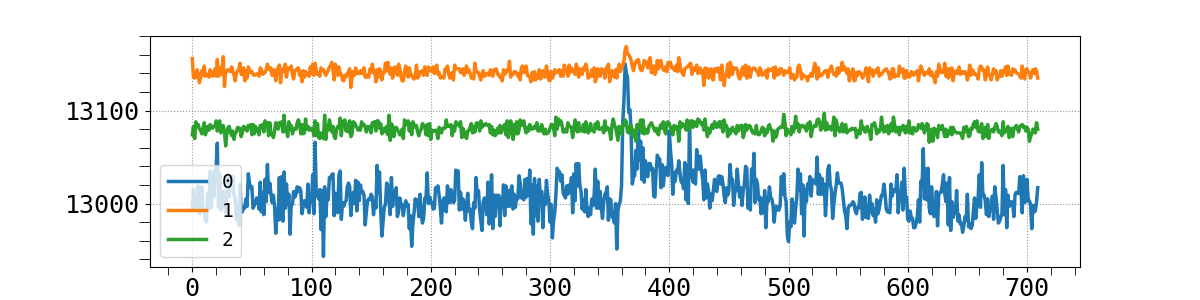

In [305]:
## to use this cell, run the above cell once
plt.close(1)
plt.figure(1, figsize=(12, 3))
#### Note: this way of looping skips one event every time we execute the for loop. Probably better not to use this loop in full code. 
for nev, event in enumerate(m.midas): # oddly doing m.midas shifts the 'pointer' to the next event
    if nev > 0: break
    wfs = event.adc_data
    for i,wf in enumerate(event.adc_data): # over channels
        wfs[i] = wf#-event.adc_baseline[i]
        # plt.plot(wfs[i], label=f'{i}')
        plt.plot(wfs[i][np.arange(50, 760)], label=f'{i}')
# plt.xlim(tmin,tmax)
plt.legend()

# 2. <a id='toc2_'></a>[Numpy part](#toc0_)

- we use numpy file from here onwards!

In [306]:
# wfs_arr = np.load("../finger_plots/midas_wfs_ls.npy", allow_pickle=True) # all preselected events for processing

In [307]:
wfs_arr = wfs

In [308]:
## we are saving select waveforms
# new_wfs_ls.append(wfs)
# new_wfs_ls = list(new_wfs_ls)
# print(new_wfs_ls)
# len(new_wfs_ls)
# np.save("../finger_plots/midas_wfs_ls.npy", new_wfs_ls, allow_pickle=True)

## 2.1. <a id='toc2_1_'></a>[data selection](#toc0_)

In [309]:
# og_wfs = wfs_arr[0].copy() # had success with [3] # [2] has multiple peaks
og_wfs = wfs_arr.copy()

In [310]:
n_channel = 0

In [311]:
tmin = 0
tmax = min(og_wfs[n_channel].shape[0], 1750)

## 2.2. <a id='toc2_2_'></a>[data preprocessing](#toc0_)

In [312]:
## this approach is not going to be used.
# # dividng by area under the curve so that new area under the curve = 1
# for _c in range(3):
#     wfs[_c] = np.divide( wfs[_c], simpson(wfs[_c] ) )

In [313]:
# temp
# simpson(wfs[2])

In [314]:
# temp
# 0.0010*simpson(wfs[2])

In [315]:
### shifting
def transform_shift_wfs(og_wfs:np.ndarray) -> tuple:
    wfs = np.copy(og_wfs)
    shift_values = {}
    for _c in range(3):
        a = np.min(og_wfs[_c])
        if a < 0:
            print(f"channel {_c} below {0}: value of min element = {a}.")
            wfs[_c] = og_wfs[_c] + np.abs(a)
            shift_values[str(_c)] = a
        else:
            shift_values[str(_c)] = 0
    return (wfs, shift_values)

In [316]:
wfs, shift_values = transform_shift_wfs(og_wfs)
# wfs[2]

In [317]:
shift_values

{'0': 0, '1': 0, '2': 0}

## 2.3. <a id='toc2_3_'></a>[Plotting npy data](#toc0_)

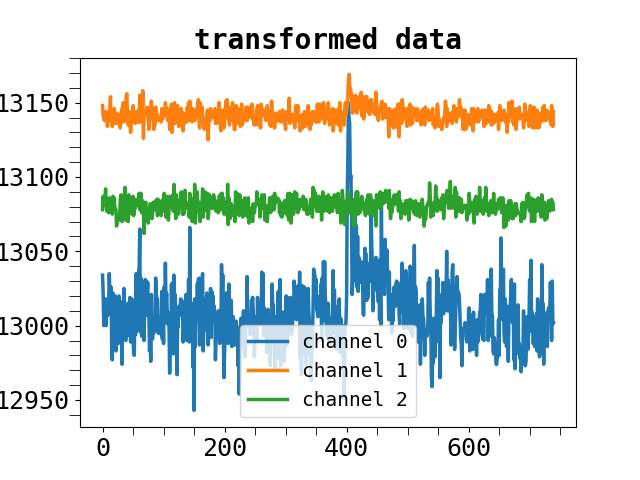

In [318]:
plt.close(2)
plt.figure(2)
plt.title('transformed data')
from matplotlib.offsetbox import AnchoredText
for _c in range(3):
    # plt.plot(wfs[_c], label=f'channel {_c}')
    plt.plot(wfs[_c][10:750], label=f'channel {_c}') # pyreco modified

plt.legend()

plt.grid()

## 2.4. <a id='toc2_4_'></a>[Template function](#toc0_)

In [319]:
# template as original given passed by Marcin
# def simplesum(t, t0, sigma, tau, scale):
#     return (1-scale)/(sigma*np.sqrt(2*np.pi))*np.exp(-((t-t0)/(sigma))**2/2) + scale*np.heaviside(t-t0,1)/tau*np.exp(-(t-t0)/tau)

# @latexify.function
def simplesum(t, t0, sigma, tau, scale, baseline, K):
    return baseline + K*((1-scale)/(sigma*np.sqrt(2*np.pi))*np.exp(-((t-t0)/(sigma))**2/2) + scale*np.heaviside(t-t0,0)/tau*np.exp(-(t-t0)/tau))

In [320]:
# @latexify.function()
# simplesum

## 2.5. <a id='toc2_5_'></a>[Fit range](#toc0_)

In [321]:
# fit_begin = 400
# fit_end = 600
# fit_begin = 325 # 400 #350
# fit_end = 775 # 600 # THIS gives best result # 650  # this must be optimal
fit_begin = 0
# fit_end = wfs[2].shape[0] -1 
fit_end  = 1750 # hardcoded
x_values = np.arange(tmin, tmax+1)
# x_values = np.arange(tmin, tmax)

## 2.6. <a id='toc2_6_'></a>[Fitter](#toc0_)

In [322]:
mse_700_800 = np.std(wfs[2][700:800])/np.sqrt(wfs[2][700:800].shape[0])

In [323]:
np.std(wfs, axis=1)

array([      6451,       6518,       6488])

In [324]:
np.std(wfs[2][600:700])

4.767557026402515

In [325]:
# np.std(wfs[2][700:800])/np.sqrt(wfs[2][700:800].shape[0])

In [326]:
## use rmse_700_800 into the curve_fit

In [327]:
x_values[fit_begin:fit_end+1].shape

(1751,)

In [328]:
wfs[2][fit_begin:fit_end+1].shape

(1751,)

In [329]:
fit_end

1750

In [330]:
p0_input = [440.0,   2.5,  80.0,   0.95, 0.0, 10000.0] #t0=416, sigma=1.85, tau=87, scale=0.98, baseline=0.0002, K=12560

fittedparameters, pcov = curve_fit(simplesum, x_values[fit_begin:fit_end+1], wfs[2][fit_begin:fit_end+1], \
                                    p0 = p0_input, \
                                    # sigma=mse_700_800*np.ones(wfs[2].shape), \
                                    bounds = ([0, 0, 0, 0, -np.inf, 0], \
                                              [np.inf, 10, np.inf, 1, np.inf, np.inf])
                                    )

In [331]:
fittedparameters

array([   0.05056,    0.05037,      789.4,     0.9998,  1.303e+04,
        5.946e+04])

In [332]:
# pcov

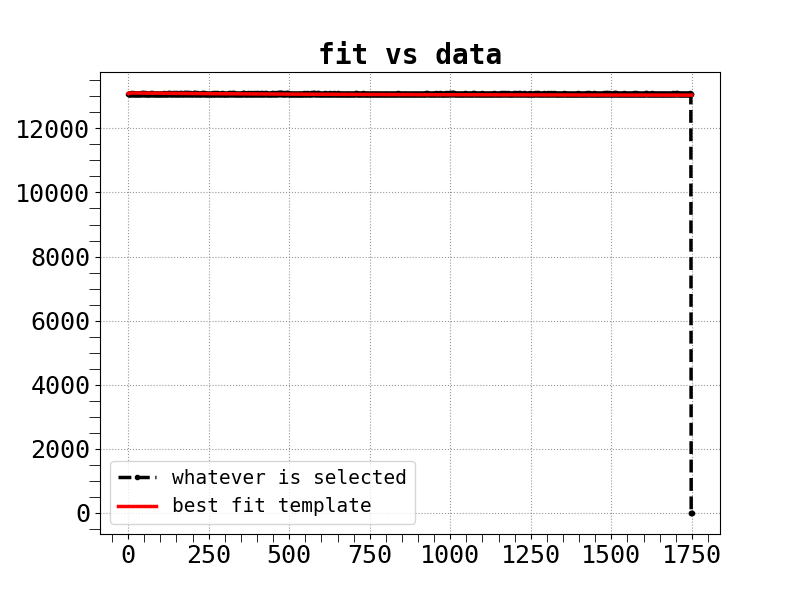

In [333]:
x_values = x_values[:wfs[1][fit_begin:fit_end+1].shape[0]]

plt.close(3)
plt.figure(3, figsize=(8,6))
plt.title('fit vs data')
plt.plot(x_values, wfs[2][fit_begin:fit_end+1], '.--', color='black', alpha=1.0, label='whatever is selected')
# plt.plot(x_values, wfs[2], '.--', color='black', alpha=1.0, label='whatever is selected')
# plt.plot(x_values[fit_begin:fit_end+1], wfs[2][fit_begin:fit_end+1], '.--', color='C2', alpha=0.1, label='whatever is selected')
# plt.plot(x_values[fit_begin:fit_end+1], wfs[2][fit_begin:fit_end+1]/auc, '.--', color='C2', alpha=0.1, label='whatever is selected')
plt.plot(x_values[fit_begin:fit_end+1], simplesum(x_values[fit_begin:fit_end+1], *fittedparameters), \
        '-', color='red', alpha=1.0, label='best fit template');

# plt.plot(x_values[fit_begin:fit_end+1], simplesum(x_values[fit_begin:fit_end+1], t0=400, sigma=10, tau=10, scale=0.9), \
#          '.-', color='purple', label='neat');

# plt.xlim(300, 800)
# plt.xticks()
plt.legend()
plt.minorticks_on()
ax = plt.gca()
# ax.set_xticks(x_values[:50:], minor=True)
## ax.xaxis.set_minor_locator(plt.MaxNLocator(5))
# ax.xaxis.set_minor_locator(AutoMinorLocator())
# ax.xaxis.set_minor_formatter(FormatStrFormatter("%i"))
# ax.tick_params(axis="x", which="both", rotation=90)
# plt.xlim(200, 1000)
plt.show()

### 2.6.1. <a id='toc2_6_1_'></a>[Chi-Square](#toc0_)

In [334]:
### As usual, scipy.stat chisquare doesn't work for me.
# chisquare(wfs[2][fit_begin:fit_end+1], simplesum(x_values[fit_begin:fit_end+1], *fittedparameters))

In [335]:
def red_chisq(f_obs, f_exp, fittedparameters):
    # chisqr = np.sum((f_obs - f_exp)**2 / f_exp)
    chisqr = np.sum((f_obs - f_exp)**2 / np.abs(f_exp)) # changed
    ndf = f_obs.shape[0]
    return chisqr/(ndf -fittedparameters.shape[0])

In [336]:
print( colored('Reducded Chisquare:', 'red', attrs = ['blink', 'bold']) )
print( colored(red_chisq(wfs[2][fit_begin:fit_end+1], \
            simplesum(x_values[fit_begin:fit_end+1], *fittedparameters), \
            fittedparameters 
          )
, 'cyan', attrs= ['bold'])
)

Reducded Chisquare:
22.47698867791659


### 2.6.2. <a id='toc2_6_2_'></a>[Getting back actual parameters](#toc0_)

In [337]:
def reverse_transform_param(fittedparameters:np.ndarray, shift_values:dict, n_channel:int)->np.ndarray:
    fittedparameters[4] = fittedparameters[4] + shift_values[str(n_channel)]
    return fittedparameters

In [338]:
fittedparameters_transformed  = reverse_transform_param(fittedparameters, shift_values, n_channel)

In [339]:
fittedparameters_transformed

array([   0.05056,    0.05037,      789.4,     0.9998,  1.303e+04,
        5.946e+04])

### 2.6.3. <a id='toc2_6_3_'></a>[plotting original data vs template with transformed parameters](#toc0_)

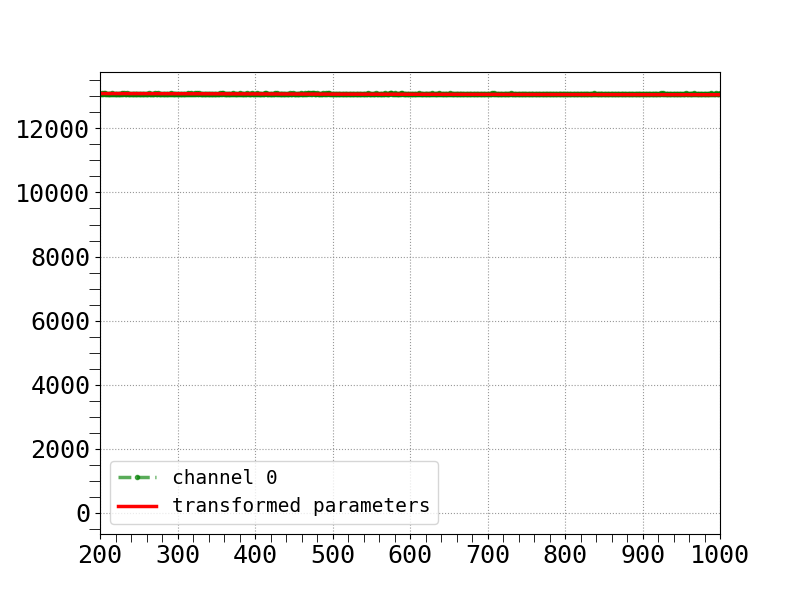

In [340]:
plt.title('best fit overlayed on untransformed data')
plt.close(4)
plt.figure(4, figsize=(8,6))
# plt.plot(x_values, og_wfs[2], '.--', color='green', alpha=0.65, label=f'channel {n_channel}')
plt.plot(x_values, og_wfs[2][:x_values.shape[0]], '.--', color='green', alpha=0.65, label=f'channel {n_channel}') # only when using pyreco vector length = 4000
# plt.plot(x_values[fit_begin:fit_end+1], simplesum(x_values[fit_begin:fit_end+1], t0=416, sigma=2.5, tau=84, scale=0.97), \
#          '+', color='purple', label='neat');
plt.plot(x_values[fit_begin:fit_end+1], \
                    simplesum(x_values[fit_begin:fit_end+1], *fittedparameters_transformed), \
                                                    # simplesum(x_values[fit_begin:fit_end+1],                     
                                                #   t0=416, sigma=1.85, tau=100, scale=0.98, 
                                                #   baseline_pre=0.0013, 
                                                #   baseline_post = 0.000005, 
                                                #   K=12560), \
         '-', color='red',alpha=1.0, label='transformed parameters');

plt.xlim(200, 1000)
plt.legend()
# plt.show()

# 3. <a id='toc3_'></a>[ARMA Filter](#toc0_)
This method will be used in a function to generate a catalog of clean waveforms.

**Tasks**: 
- find number of peaks & if n_peaks > 1 -> reject waveform
- Avoid edges
- Avoid double peaks?

ARMA:

In [341]:
from pyreco.reco.filtering import WFFilter
mfilter = WFFilter(m.config) # ToDo verify the that we are using the right config file.

## coplot ARMA in action

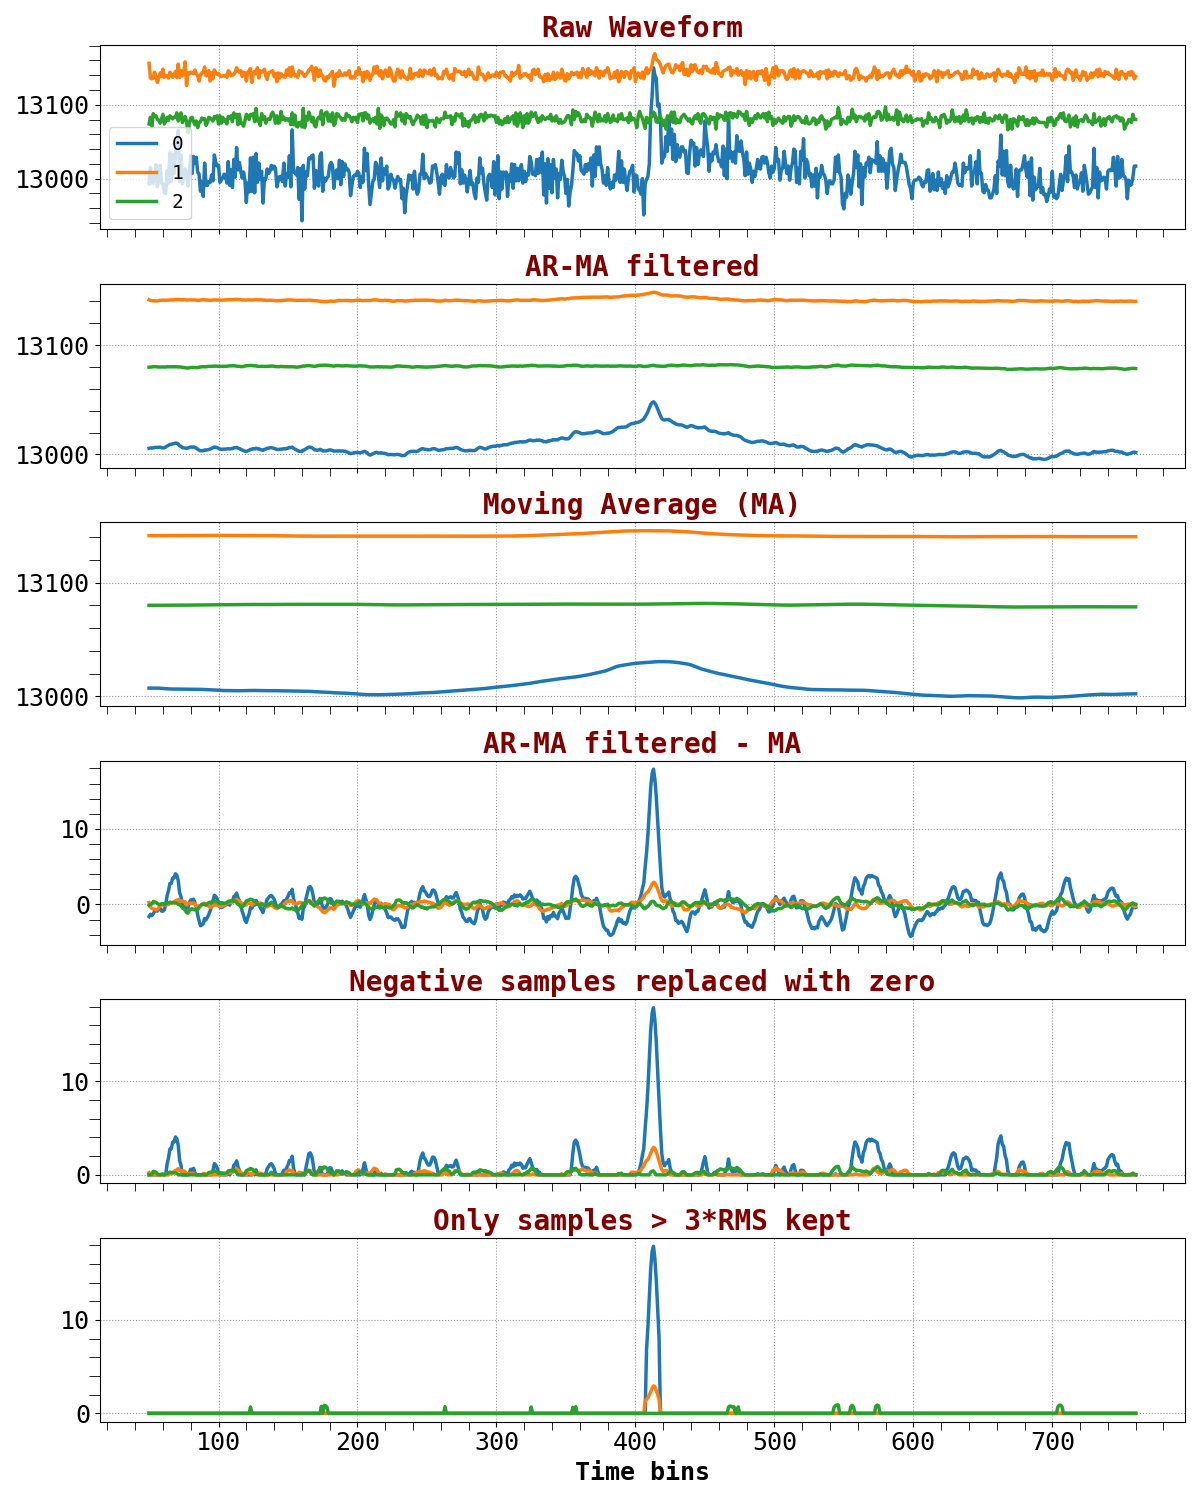

In [342]:
plot_range_demo = np.arange(50, 761)        # range of sample to be considered
wf = np.zeros((3, plot_range_demo.shape[0]))
for i in range(3):
    wf[i] = wfs[i][plot_range_demo]
flt = np.reshape(mfilter.numba_fast_filter(wfs), newshape=wfs.shape)
arflt = np.zeros((3, wf.shape[1]))
for zz in range(3):
    arflt[zz] = flt[zz][plot_range_demo]
flt = arflt
mas = m.algos.running_mean(flt, gate=60)
fig1, ax1 = plt.subplots(6,1, figsize=(12, 15),  sharex = True)
flt_above_3rms = np.zeros([3, plot_range_demo.shape[0]])
rms = np.zeros([3,])
for i in range(3):
    ax1[0].plot(plot_range_demo, wf[i], label=f'{i}') # wf
    ax1[1].plot(plot_range_demo, flt[i], label=f'{i}') # flt
    ax1[2].plot(plot_range_demo, mas[i], label=f'{i}') # mas

    flt_proc_all = flt - mas
    ax1[3].plot(plot_range_demo, flt_proc_all[i], label=f'{i}') # flt - mas

    flt_proc_all = np.where(flt_proc_all>0,flt_proc_all, 0)
    ax1[4].plot(plot_range_demo, flt_proc_all[i], label=f'{i}') # > 0

    # rms[i] = m.algos.get_rms(flt_proc_all[i])
    rms = m.algos.get_rms(flt_proc_all)
    flt_above_3rms = np.where(flt_proc_all > 3*rms, flt_proc_all, 0)
    ax1[5].plot(plot_range_demo, flt_above_3rms[i], label=f'{i}') # flt_above_3rms

ax1[0].set_title('Raw Waveform', color='maroon')
ax1[1].set_title('AR-MA filtered', color='maroon')
ax1[2].set_title('Moving Average (MA)', color='maroon')
ax1[3].set_title('AR-MA filtered - MA', color='maroon')
ax1[4].set_title('Negative samples replaced with zero', color='maroon')
ax1[5].set_title('Only samples > 3*RMS kept', color='maroon')
ax1[0].legend()
ax1[5].set_xlabel('Time bins')
# for j in range(6):
    # ax1[j].set_ylabel('Amplitude [ADC units]')
fig1.tight_layout()
# fig1.subplots_adjust(wspace=0, hspace=0)

In [347]:
fig1.savefig('../output/ARMA_in_action.png', dpi=300)

In [348]:
pwd

'/home/sarthak/my_projects/argset/notebooks'

In [ ]:
# np.ceil(np.mean(np.where(flt_above_3rms != 0)))

In [345]:
# _all
# len(find_peaks(flt_above_3rms_all[1])[0])

In [346]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

# 4. <a id='toc4_'></a>[Read pickled clean event catalogue](#toc0_)
<p>  pickle file generated by calculate_wf_param.py </p>

In [ ]:
# import pandas as pd
# saved_pkl_file = '../data/argset_clean_catalogue_100_000.pkl' 
# current_pkl_file = "../temp_folder/argset_wfs_catalogue.pkl"
current_pkl_file = "../temp_folder/argset_wfs_catalogue_100_1000.pkl"
# df_file = pd.read_pickle(saved_pkl_file)
df_file = pd.read_pickle(current_pkl_file)

In [ ]:
df_file.shape

In [ ]:
(df_file['chisqr_ch2'] < 2.0).sum()/(df_file['chisqr_ch2'].shape[0])

In [ ]:
n_channel = 2
param_ch2 = df_file.iloc[3]['fit_param_ch2']
clean_wf = df_file.iloc[3]['wf'][2]
a = np.min(clean_wf)

plt.title('clean waveforms')
plt.close(8)
plt.figure(8, figsize=(8,6))
plt.plot(clean_wf+np.abs(a), '-', color='green', alpha=0.65, label=f'channel {n_channel}')
plt.plot(simplesum(x_values, *param_ch2), '-', color='red', alpha=0.65, label=f'template')

plt.legend()
plt.show()

In [ ]:
t0_ls = []
sigma_ls = []
tau_ls = []
scale_ls = []
for i in range(df_file.shape[0]):
    t0_ls.append(df_file['fit_param_ch2'][i][0])
    sigma_ls.append(df_file['fit_param_ch2'][i][1])
    tau_ls.append(df_file['fit_param_ch2'][i][2])
    scale_ls.append(df_file['fit_param_ch2'][i][3])


In [ ]:
n_param = df_file['fit_param_ch2'][0].shape[0]
# param_ls = ['t0_ls', 'sigma_ls', 'tau_ls', 'scale_ls'] # temp
param_dict = {
't0': t0_ls, 
'sigma': sigma_ls, 
'tau': tau_ls,
'scale': scale_ls
}
# for _i in range(n_param):
# for _i in range(len(param_ls)):
# _i = 0
# for param_key, param in param_dict:
# for _i, param_key in enumerate(param_dict):
#     plt.figure(9+_i)
#     plt.hist(param_dict[param_key])
#     plt.title(param_key)
#     plt.show()


In [ ]:
plt.close(9)
plt.figure(9)
plt.hist(param_dict['t0'])
plt.title('to')
plt.show()

In [ ]:
plt.close(10)
plt.figure(10)
plt.hist(param_dict['sigma']) #, bins= np.linspace(1.0, 6.0, 10))
plt.title('sigma')
plt.show()

In [ ]:
plt.close(11)
plt.figure(11)
plt.hist(param_dict['tau'], bins= np.linspace(0.0, 150.0, 10))
plt.title('tau')
plt.show()

In [ ]:
plt.close(12)
plt.figure(12)
plt.hist(param_dict['scale'], bins= np.linspace(0.4, 1.0, 10))
plt.title('scale')
plt.show()

In [ ]:
# 5 of 100
# 50,000 # incorrect
# 2500 clean events
# -> 100, 000
# -> 2 Millions events in total

In [ ]:
## selection on values
## https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html

In [ ]:
df_file[(df_file['chisqr_ch2'] < 2) & (df_file['chisqr_ch2'] >= 1.0)].shape

## 4.1. <a id='toc4_1_'></a>[How to increase statistics for parameters](#toc0_)

In [ ]:
clean_target = 100000
success_rate_of_search_algorithm = 0.91
clean_ratio = 0.05

# @latexify.function
def total_events_tobe_scanned(clean_target, clean_ratio, success_rate_of_search_algorithm):
    # total_events = clean_target * 1/clean_ratio *1/success_rate_of_search_algorithm
    # return total_events
    return clean_target * 1/clean_ratio *1/success_rate_of_search_algorithm

In [ ]:
total_events_tobe_scanned(clean_target, clean_ratio, success_rate_of_search_algorithm)


In [ ]:
f'number of files {(total_events_tobe_scanned(clean_target, clean_ratio, success_rate_of_search_algorithm))/(100000)}'

# 5. <a id='toc5_'></a>[Reading pickled event catalogue](#toc0_)

In [ ]:
# event_catalogue_file = f'../temp_folder/copy_event_catalogue_run0061.pkl'
# event_catalogue_file = f'../temp_folder/event_catalogue_run0061.pkl'
event_catalogue_file = f'../data/event_catalogue_run00061_3ch.pkl'
event_catalogue = pd.read_pickle(event_catalogue_file)

In [ ]:
event_catalogue.info()

In [ ]:
event_catalogue.shape

In [ ]:
wf_ch2 = event_catalogue['wf_ch2']

In [ ]:
wf_ch2[1]

In [ ]:
# wf_1.iloc[1]

In [ ]:
# event_catalogue.iloc[1]['wf'][2]

# 6. <a id='toc6_'></a>[trash this](#toc0_)

In [ ]:
### temp
a_index = [1,2,3,4,5,10,11]
a_data = ['Delhi', 'Kolkata', 'New YOrk', 'London', \
    'Yorkshire', 'Warsaw', 'Sidney']
b_index = [1,2,3,7,8,9,10,12]
b_data = ['Amy', 'Amelia', 'Angela', 'Khushi', \
    'Aishwarya', 'Barbara', 'Anshu', 'Amanda']
a_dict = {'index': a_index, 'city': a_data}
b_dict = {'index': b_index, 'person': b_data}
a_df = pd.DataFrame.from_dict(a_dict)
b_df = pd.DataFrame.from_dict(b_dict)
# df_a = pd.DataFrame()

In [ ]:
a_df

In [ ]:
b_df

In [ ]:
a_df.join(b_df.set_index('index'), on= 'index', how='outer')

# 7. <a id='toc7_'></a>[altenative file formats](#toc0_)

## 7.1. <a id='toc7_1_'></a>[npz](#toc0_)

<p>
z is compressed.
</p>

In [ ]:
event_index_arr = np.array(event_catalogue['event_index'])

In [ ]:
event_counter_arr = np.array(event_catalogue['event_counter'])

In [ ]:
wf_arr = np.array(event_catalogue['wf'], dtype=np.ndarray)

In [ ]:
wf_arr

In [ ]:
# np.savez_compressed('../temp_folder/event_catalogue.npz', event_index=event_index_arr, \
#                     event_counter=event_counter_arr, wf = wf_arr)

In [ ]:
loaded = np.load('../data/event_catalogue_run00061.npz', allow_pickle = True)

In [ ]:
loaded

In [ ]:
wf = loaded['wf']

In [ ]:
wf.shape

In [ ]:
wf[1]

In [ ]:
loaded['event_counter'].shape[0]

In [ ]:
# wf[0][2]

In [ ]:
# wf.shape

In [ ]:
# loaded['event_index']

In [ ]:
# loaded['event_counter']

## 7.2. <a id='toc7_2_'></a>[HDF5](#toc0_)

In [ ]:
# event_catalogue_hdf_filename = f'../temp_folder/event_catalogue_run0061.hdf'
# event_catalogue.to_hdf(event_catalogue_hdf_filename, key='event_catalogue', mode='a')


## 7.3. <a id='toc7_3_'></a>[parquet](#toc0_)

In [ ]:
# event_catalogue_par_filename = f'../temp_folder/event_catalogue_run0061.parquet'
# event_catalogue.to_parquet(event_catalogue_par_filename)

## 7.4. <a id='toc7_4_'></a>[h5py on numpy array](#toc0_)

In [ ]:
## Doesn't works for array of arrays
# import h5py

In [ ]:
import h5py

### 7.4.1. <a id='toc7_4_1_'></a>[write h5 file](#toc0_)

In [ ]:
# with h5py.File('demo.h5', 'w') as dem:
#     dem.create_dataset('event_counter', data = event_counter, compression="gzip")
#     dem.create_dataset('wf_ch0', data = wf_ch0, compression="gzip")
#     dem.create_dataset('wf_ch1', data = wf_ch1, compression="gzip")
#     dem.create_dataset('wf_ch2', data = wf_ch2, compression="gzip")

### 7.4.2. <a id='toc7_4_2_'></a>[read h5 file](#toc0_)

In [ ]:
# event_h5 = h5py.File('../data/event_catalogue_run00061_3Ch.h5', 'r')
event_h5 = h5py.File('../temp_folder/argset_clean_catalogue.h5', 'r')

In [ ]:
event_h5['clean_ch1']
#.close()

In [ ]:
event_h5['clean_ch2']

In [ ]:
event_h5.close()

In [ ]:
event_counter = np.array(event_h5['event_counter'])

In [ ]:
event_counter = event_h5.get('event_counter')

In [ ]:
event_counter

In [ ]:
wf_ch0 = event_h5.get('wf_ch0')

In [ ]:
wf_ch1 = event_h5.get('wf_ch1')

In [ ]:
wf_ch2 = event_h5.get('wf_ch2')

# 8. <a id='toc8_'></a>[Memory diagnostics](#toc0_)

In [ ]:
# ## see memory usage
!cat /proc/meminfo

In [ ]:
# event_catalogue.info(memory_usage='deep')

In [ ]:
# del event_catalogue

In [ ]:
# !cat /proc/meminfo

In [ ]:
# import gc
# gc.isenabled()

In [ ]:
# gc.collect()

# 9. <a id='toc9_'></a>[reading pickle file](#toc0_)

import pickle

In [ ]:
import pickle

In [ ]:
dict_pkl_filename = '../temp_folder/argset_clean_dict_3Ch.pkl' #argset_clean_dict_3Ch.pkl

In [ ]:
handle = open(dict_pkl_filename, 'rb')
dict_file = pickle.load(handle)

In [ ]:
dict_file['ch0'].shape

In [ ]:
dict_file['ch1'].shape

In [ ]:
dict_file['ch2']

# 10. <a id='toc10_'></a>[Read auxiliary files](#toc0_)
possibe bug in baseline substraction or waveform shifting

In [ ]:
clean_dict_filename = r'../temp_folder/clean_catalogue_dict.pkl'
clean_dict_handle = open(clean_dict_filename, 'rb')

In [ ]:
clean_dict = pickle.load(clean_dict_handle)

In [ ]:
fit_dict_filename = r'../temp_folder/fit_catalogue_dict.pkl'
fit_dict_handle = open(fit_dict_filename, 'rb')

In [ ]:
fit_dict =pickle.load(fit_dict_handle)

In [ ]:
# # df_fit['ch2']
# for i in range(4):
#     print(df_fit['ch2'].iloc[i]['event_counter'], '-- -- --', df_fit['ch2'].iloc[i]['wf_ch2'])

In [ ]:
# # old_catalog_open.head()
# for i in range(4):
#     print(old_catalog_open.iloc[i]['event_index'], '-- ---', old_catalog_open.iloc[i]['wf'][2])

In [ ]:
old_catalogue_file = r'../temp_folder/argset_wfs_catalogue_100_1000.pkl'

In [ ]:
old_catalogue_handle = open(old_catalogue_file, 'rb')
old_catalog_df = pickle.load(old_catalogue_handle)

In [ ]:
## This is the event catalogue currently under use
event_catalogue_filename = '/home/sarthak/my_projects/argset/data/event_catalogue_run0061.pkl'
event_handle = open(event_catalogue_filename, 'rb')
event_catalog_df = pickle.load(event_handle)

In [ ]:
old_catalog_df.head()

In [ ]:
clean_dict['ch2']

In [ ]:
clean_dict['ch2'].iloc[2]['wf_ch2'] 

In [ ]:
fit_dict['ch2'].iloc[2]['wf_ch2']

In [ ]:
fit_dict['ch2'].iloc[2]['wf_ch2'] - clean_dict['ch2'].iloc[2]['wf_ch2']

In [ ]:
tmp_wf = clean_dict['ch2'].iloc[2]['wf_ch2']

In [ ]:
min(tmp_wf)

In [ ]:
# for event_index in range(3): #range(old_catalog_open.shape[0]):
#     wf = old_catalog_open.iloc[event_index]['wf']
#     for _c in range(3):
#         if min(wf[_c]) < 0:
#             old_catalog_open.iloc[event_index]['wf'][_c] = wf[_c] + np.abs(min(wf[_c]))